In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [2]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from scipy import stats
from scipy import signal
from sklearn import decomposition
from Behavior.behavior import get_extent, get_idxs_behav_state, get_idxs_in_patches
from Behavior.behavior import density_map, density_map, get_idxs_neuro_state
from target import get_spike_counts

from population import unit_response_matrix, activity_at_phase

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'

sessions = [s for s in selected_009266.keys()]
#sessions = [s for s in selected_009265.keys()]
#sessions = [s for s in selected_008229.keys()]
sessions.sort()

selected = sessions[:]
try:
    selected.remove('009266_hippoSIT_2023-04-20_15-24-14')
except:
    pass
try:
    selected.remove('009265_hippoSIT_2023-02-27_10-18-32')
    selected.remove('009265_hippoSIT_2023-02-27_15-33-46')
except:
    pass

# special for 009265
#selected = selected[7:-1]
selected

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35']

## SNR

In [16]:
SNR_collection = []
speed_thresh = 0.04  # m/s

for k, session in enumerate(selected):
    # read spike- and meta- data
    animal     = session.split('_')[0]
    meta_file  = os.path.join(source, animal, session, 'meta.h5')
    units_file = os.path.join(source, animal, session, 'units.h5')
    desc_file  = os.path.join(source, animal, session, 'descendants.h5')
    state_file = os.path.join(source, animal, session, 'analysis', 'state_idxs.h5')
    
    with h5py.File(meta_file, 'r') as f:
        events = np.array(f['processed']['sound_events'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        tl     = np.array(f['processed']['timeline'])
    with h5py.File(desc_file, 'r') as f:
        speed = np.array(f['speed'])
    with h5py.File(state_file, 'r') as f:
        idxs_AL_ev = np.array(f['idxs_AL_ev'])  # bAL state
        idxs_neuro_AL_bgr_ev = np.array(f['idxs_neuro_AL_bgr_ev'])
        idxs_neuro_AL_sil_ev = np.array(f['idxs_neuro_AL_sil_ev'])
        idxs_neuro_PH_bgr_ev = np.array(f['idxs_neuro_PH_bgr_ev'])
        idxs_neuro_PH_sil_ev = np.array(f['idxs_neuro_PH_sil_ev'])
    single_units, spike_times = {}, {}
    with h5py.File(units_file, 'r') as f:
        unit_names = [x for x in f]
    with h5py.File(units_file, 'r') as f:
        for unit_name in unit_names:
            spike_times[unit_name]  = np.array(f[unit_name][H5NAMES.spike_times['name']])
            single_units[unit_name] = np.array(f[unit_name][H5NAMES.inst_rate['name']])
    spike_times_A1 = dict([(name, spk_times) for name, spk_times in spike_times.items() if int(name[0]) < 3])

    # speed filter
    idxs_sta_ev = np.where(speed[events[:, 2].astype(np.int32)] < speed_thresh)[0]
    idxs_run_ev = np.where(speed[events[:, 2].astype(np.int32)] > speed_thresh)[0]
    
    # events filter
    idxs_bgr_ev = np.where(events[:, 1] == 1)[0]
    idxs_sil_ev = np.where(events[:, 1] == 0)[0]
    idxs_tgt_ev = np.where(events[:, 1] == 2)[0]
    
    idxs_bgr_sta_ev = np.intersect1d(idxs_sta_ev, idxs_bgr_ev)
    idxs_sil_sta_ev = np.intersect1d(idxs_sta_ev, idxs_sil_ev)
    idxs_tgt_sta_ev = np.intersect1d(idxs_sta_ev, idxs_tgt_ev)
    
    # state separation. Silence bAL / bPH doesn't make sense
    # cause there is no 'evoked' part. But can be there for test anyway
    idxs_AL_bgr_ev  = np.intersect1d(idxs_AL_ev, idxs_bgr_ev)
    idxs_AL_sil_ev  = np.intersect1d(idxs_AL_ev, idxs_sil_ev)

    idxs_PH_ev = np.array([x for x in range(len(events)) if not x in idxs_AL_ev])
    idxs_PH_bgr_ev = np.intersect1d(idxs_PH_ev, idxs_bgr_ev)
    idxs_PH_sil_ev = np.intersect1d(idxs_PH_ev, idxs_sil_ev)

    idxs_AL_bgr_sta_ev = np.intersect1d(idxs_AL_bgr_ev, idxs_sta_ev)
    idxs_PH_bgr_sta_ev = np.intersect1d(idxs_PH_bgr_ev, idxs_sta_ev)
    idxs_AL_sil_sta_ev = np.intersect1d(idxs_AL_sil_ev, idxs_sta_ev)
    idxs_PH_sil_sta_ev = np.intersect1d(idxs_PH_sil_ev, idxs_sta_ev)
    
    idxs_PH_bgr_run_ev = np.intersect1d(idxs_PH_bgr_ev, idxs_run_ev)
    
    # get pulse times
    t_sil = events[idxs_sil_sta_ev][:, 0]
    t_bgr = events[idxs_bgr_sta_ev][:, 0]
    t_tgt = events[idxs_tgt_sta_ev][:, 0]
    t_bAL_bgr_sta = events[idxs_AL_bgr_sta_ev][:, 0]
    t_bPH_bgr_sta = events[idxs_PH_bgr_sta_ev][:, 0]
    t_bPH_bgr_run = events[idxs_PH_bgr_run_ev][:, 0]
    #t_bAL_sil = events[idxs_AL_sil_sta_ev][:, 0]
    #t_bPH_sil = events[idxs_PH_sil_sta_ev][:, 0]
    
    # compute SNR
    hw, bc = 0.25, 41  # FIXME: do 31 bins?
    times_list = [t_sil, t_bgr, t_tgt, t_bAL_bgr_sta, t_bPH_bgr_sta, t_bPH_bgr_run]
    SNR_mx = np.zeros([len(spike_times_A1), len(times_list)])

    for i, (unit, spk_times) in enumerate(spike_times_A1.items()):
        for j, psth_times in enumerate(times_list):
            bins, psth_profile = get_spike_counts(spk_times, psth_times, hw, bc)

            idxs_b_noise  = np.where(bins > 0.101)[0][:-1]
            idxs_b_sig    = np.where((bins > 0) & (bins <= 0.101))[0]
            idxs_b_noi_w1 = np.where(bins > 0.04)[0][:-1]  # only 2 bins (with 41 binning)
            idxs_b_sig_w1 = np.where((bins >= 0) & (bins <= 0.04))[0]  # the rest
            #raise ValueError
            
            # option 1
            #noise = psth_profile[idxs_b_noise].mean()
            #sig   = np.abs(psth_profile[idxs_b_sig] - noise).mean() + noise
            #snr1  = sig/noise
            
            # option 2: only W1 as sig, the rest is noise
            noise = psth_profile[idxs_b_noi_w1].mean()
            sig   = np.abs(psth_profile[idxs_b_sig_w1] - noise).mean() + noise
            snr1  = sig/noise
            
            # option 2
            #noise_mean = psth_profile[idxs_b_noise].mean()
            #sig   = (np.abs(psth_profile[idxs_b_sig] - noise_mean).sum() + noise_mean*len(idxs_b_sig))/len(idxs_b_sig)
            #noise = (np.abs(psth_profile[idxs_b_noise] - noise_mean).sum() + noise_mean*len(idxs_b_noise))/len(idxs_b_noise)
            #snr2  = sig/noise

            # option 3
            #noise_mean = psth_profile[idxs_b_noise].mean()
            #sig   = np.abs(psth_profile[idxs_b_sig] - noise_mean).sum()/len(idxs_b_sig)
            #noise = np.abs(psth_profile[idxs_b_noise] - noise_mean).sum()/len(idxs_b_noise)
            #snr3  = (sig - noise)/noise_mean

            SNR_mx[i, j] = snr1
            
    SNR_collection.append(SNR_mx)
    print("%s done" % session)

009266_hippoSIT_2023-04-17_17-04-17 done
009266_hippoSIT_2023-04-18_10-10-37 done
009266_hippoSIT_2023-04-18_17-03-10 done
009266_hippoSIT_2023-04-19_10-33-51 done
009266_hippoSIT_2023-04-20_08-57-39 done
009266_hippoSIT_2023-04-21_08-43-00 done
009266_hippoSIT_2023-04-21_13-12-31 done
009266_hippoSIT_2023-04-24_10-08-11 done
009266_hippoSIT_2023-04-24_16-56-55 done
009266_hippoSIT_2023-04-26_08-20-17 done
009266_hippoSIT_2023-05-02_12-22-14 done
009266_hippoSIT_2023-05-04_19-47-15 done
009266_hippoSIT_2023-05-22_09-27-22 done
009266_hippoSIT_2023-05-23_09-18-05 done
009266_hippoSIT_2023-05-25_15-55-57 done
009266_hippoSIT_2023-06-14_08-21-23 done
009266_hippoSIT_2023-06-19_08-58-35 done


In [6]:
#bins[idxs_b_sig], bins[idxs_b_noise]
#bins[idxs_b_sig_w1], bins[idxs_b_noi_w1]

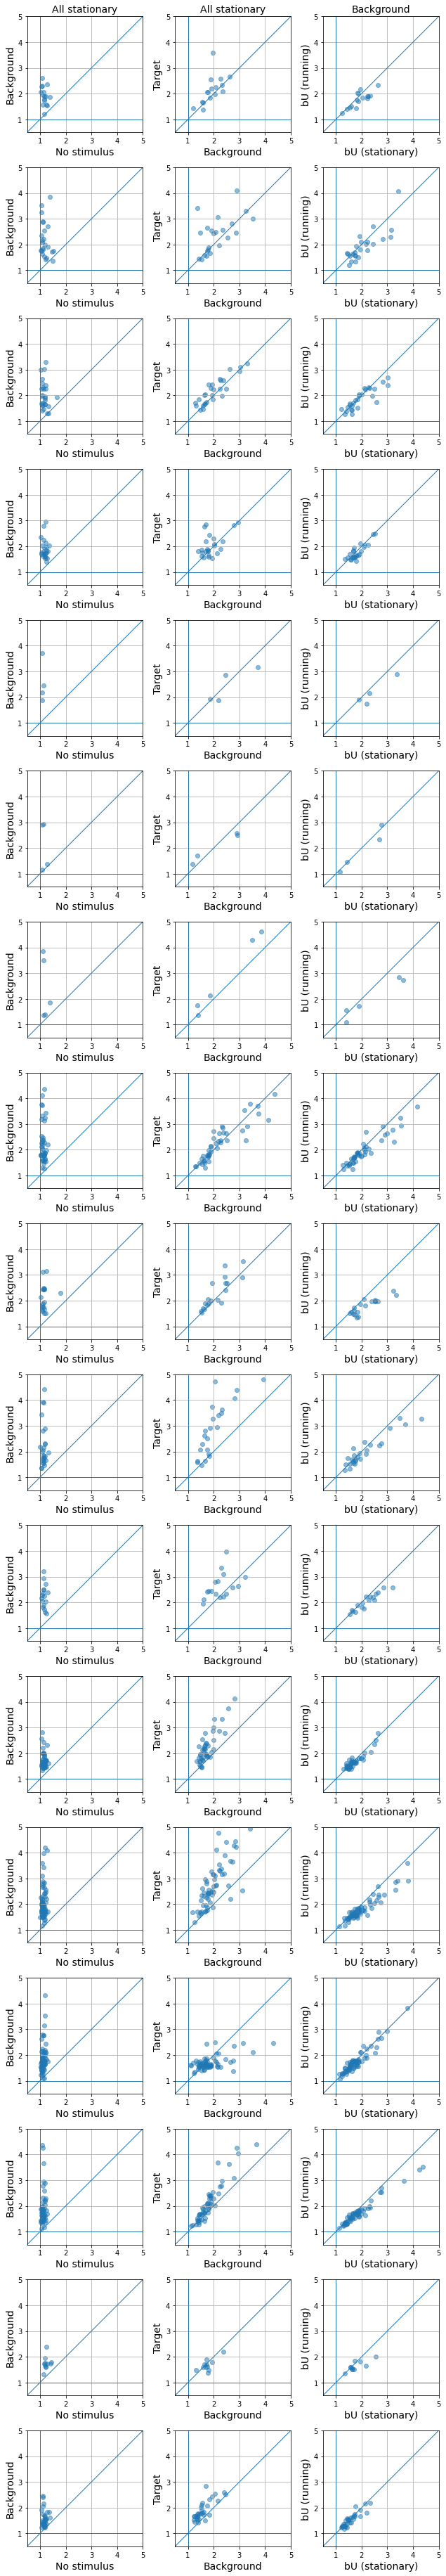

In [30]:
#combs = [[0, 1], [1, 2], [4, 3]]  # bE - bU in sta
combs = [[0, 1], [1, 2], [4, 5]]  # run - sta in bU
rows = len(selected)
cols = len(combs)
fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))

labels = [
    ['No stimulus', 'Background'],
    ['Background', 'Target'],
    #['Undetermined (bU)', 'Task engaged (bE)'],
    ['bU (stationary)', 'bU (running)'],
]
titles = ['All stationary', 'All stationary', 'Background', 'No stimulus']
x_max = 5

for j, SNR_table in enumerate(SNR_collection):
    for i, comb in enumerate(combs):
        ax = axes[j, i]
        ax.scatter(SNR_table[:, comb[0]], SNR_table[:, comb[1]], alpha=0.5)
        ax.set_xlim(0.5, x_max)
        ax.set_ylim(0.5, x_max)
        ax.set_aspect('equal', 'box')
        ax.plot([0, x_max], [0, x_max], lw=1)
        ax.set_xlabel(labels[i][0], fontsize=14)
        ax.set_ylabel(labels[i][1], fontsize=14)
        if j == 0:
            ax.set_title(titles[i], fontsize=14)
        ax.axhline(1, lw=1)
        ax.axvline(1, lw=1)
        ax.grid()
        
fig.tight_layout()

In [31]:
#fig.savefig(os.path.join(rep_path, '%s_SNR1_per_session.pdf' % animal))

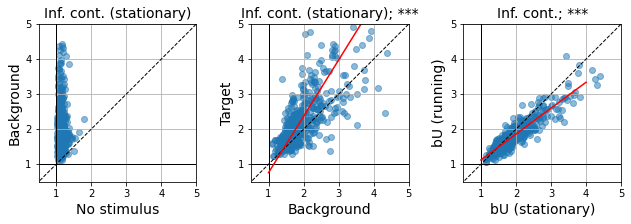

In [32]:
fig, axes = plt.subplots(1, cols, figsize=(3*cols, 3))

titles = ['Inf. cont. (stationary)', 'Inf. cont. (stationary)', 'Inf. cont.', 'SIL']
SNR_all = np.vstack(SNR_collection)
for i, comb in enumerate(combs):
    ax = axes[i]
    for j, SNR_table in enumerate(SNR_collection):
        #if j >= 7 and j <=9:
        #    continue
        ax.scatter(SNR_table[:, comb[0]], SNR_table[:, comb[1]], alpha=0.5, color='tab:blue')
    ax.set_xlim(0.5, x_max)
    ax.set_ylim(0.5, x_max)
    ax.set_aspect('equal', 'box')
    ax.set_xlabel(labels[i][0], fontsize=14)
    ax.set_ylabel(labels[i][1], fontsize=14)
    ax.axhline(1, lw=1, color='black')
    ax.axvline(1, lw=1, color='black')
    ax.plot([0, x_max], [0, x_max], lw=1, color='black', ls='--')
    ax.grid()
    ax.set_title(titles[i], fontsize=14)
    
    if i > 0:
        wil_p = stats.wilcoxon(SNR_all[:, 4], SNR_all[:, 5]).pvalue
        res = stats.linregress(SNR_all[:, comb[0]], SNR_all[:, comb[1]])
        x = np.array([1, 4])
        ax.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
        ax.set_title("%s; ***" % titles[i], fontsize=14)
    
fig.tight_layout()

In [33]:
#fig.savefig(os.path.join(report, 'showroom', '%s_SNR2_bUs_bEs.png' % animal), dpi=300)
fig.savefig(os.path.join(report, 'showroom', '%s_SNR2_bUs_bUr.png' % animal), dpi=300)

In [160]:
stats.wilcoxon(SNR_all[:, 4], SNR_all[:, 5]).pvalue

6.121983506377227e-17

In [8]:
wil_p

2.1260712006363517e-26